In [163]:
library(tidyverse)
library(tidymodels)
library(themis)
library(repr)
library(broom)
library(rvest)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 10 rows

# Project Final Report

## Introduction

#### General Information
This Final Report will be conducted on datasets provided by a research group in Computer Science at UBC, led by Frank Wood, in which the research group collected data about how players play video games. The datasets provided include `players.csv`, which provides the general information about each participant, and `sessions.csv`, which provides individual session information from each player.  

#### Aim

The aim of this final report is to gain relevent information regarding two questions. Firstly a broad question
* Which player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

and secondly, a more specific question
* How accurately can just age and just hours played predict subscription to a game-related newsletter compared to a prediction using both age and hours played in `players.csv`?

By doing so, we can help the computer science research group and their stakeholders understand their data using our specific question to gain insight into the broader question.  

#### Datasets

As stated in our specific question, we will be working on the dataset `players.csv`. 

#### Data Characteristics  
The `players.csv` represents 196 individuals who particiapated in the study, described by 7 features, including:
* `experience <chr>` - Player's experience
* `subscribe <lgl>` - Whether the player subscribed to a video game newsletter
* `hashedEmail <chr>` - Unique identifier for each player
* `played_hours <dbl>` - Total hours played
* `name <chr>` - First Name
* `gender <chr>` - Gender
* `age <dbl>` - Age in years

##### Data Summary
* `experience` is composed of
    * `Beginner`
    * `Amateur`
    * `Regular`
    * `Veteran`
    * `Pro`
* `subscribe` is composed of 144 `TRUE` and 52 `FALSE`  
* `gender` is composed of
    * `Male`
    * `Female`
    * `Non-binary`
    * `Two-Spirited`
    * `Agender`
    * `Other`
    * `Prefer not to say`
* `played_hours`
    * Maximum - 223.1 hours
    * Minimum - 0 hours
    * Average - 5.845918 Hours
* `Age`
    * Oldest - 50 years
    * Youngest - 8 years
    * Mean - 20.52 years


##### Potential Issues
* Column `Age` contains `NA`
* Dataset is male dominated
* Dataset is majority Amateur players.
* Order of experience not specified, we will be assuming `Beginner -> Amateur -> Regular -> Pro -> Veteran`

## Methods and Results

Our specific question is primarily a predictive data analysis question. We are looking to determine if just `age` or just `played_hours` can predict whether a player will subscribe to a video game newsletter more accurately then both `age` and `played_hours` can. Because `subscribe` has two categories `TRUE` if the player subscribed to a video game newsletter or `FALSE` if the player didn't, we can seperately analyze the accuracy of using `age` as to predict `subscription`, using `played_hours` to predict `subscription` and using both `age` and `played_hours` to predict `subscription`.  

In order to determine which classification method we should use, we need to first wrangle and tidy the data, then look at data visualizations regarding `age` and `played_hours`.

In [90]:
# Reading and viewing the players.csv data
url <- "https://raw.githubusercontent.com/ckwok07/DSCI-100-Project-Final-Report/refs/heads/main/data/players.csv"
players <- read_csv(url)
# Checking for NA values in Age
players_age_na <- players |>
    filter(is.na(Age))
players_age_na

# Checking for NA values in played_hours
players_played_na <- players |>
    filter(is.na(played_hours))
players_played_na

# Checking for NA values in experience
players_experience_na <- players |>
    filter(is.na(experience))
players_experience_na

# Checking for NA values in subscribe
players_subscribe_na <- players |>
    filter(is.na(subscribe))
players_subscribe_na

# Thus only the Age column has NA values. In addition to that, because the amount of NA values in Age is relatively small, 
# we can remove them from the dataset instead of imputing the individuals' age as dropping these two players will not impact
# the dataset very much.

# Removing the NA values of age from the dataframe
players <- players |>
    filter(!is.na(Age))

#In addition to that, we must turn the subscribe column into a factor data type as it has 2 categories that we are going to predict
players <- players |>
    mutate(subscribe = as.factor(subscribe))
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Regular,TRUE,7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d,0.1,Devin,Two-Spirited,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


Once our data is wrangled and tidy, we can visualize the relationships between `age` and `subscribe` as well as the relationship between `played_hours` and `subscribe`

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


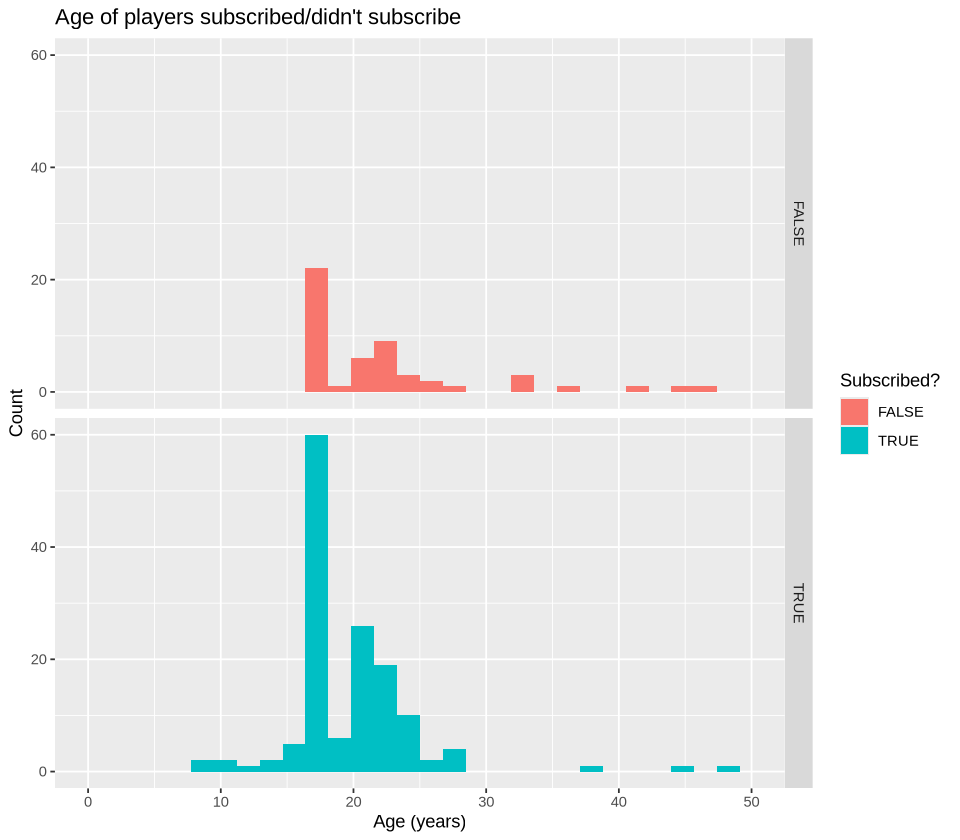

In [110]:
options(repr.plot.width = 8, repr.plot.height = 7)

# Histogram visualization of the relationship between age and subscribe
players_age_subscribe_plot <- players |>
    ggplot(aes(x = Age, fill = subscribe)) +
    geom_histogram() +
    facet_grid(rows = vars(subscribe)) +
    labs(title = "Age of players subscribed/didn't subscribe", x = "Age (years)" , y = "Count", fill = "Subscribed?") +
    xlim(c(0, 50)) +
    ylim(c(0,60))
players_age_subscribe_plot

From this visualization, we can analyze the relationship between `age` and `subscribe` in the `players.csv` dataset. In the `subscribe = TRUE` portion of the visualization, at first glance, it seems that as `age` increases, number of players subscribing to the video game newsletter decreases. However, this is not the case, becuase if it were, then the number of players not subscribed as age increases would be increasing, which is not reflected in the `subscribe = FALSE` portion of the visualization.  

Thus, there doesn't seem to be a distinct relationship shape between age and number of people subscribing to a video game newsletter.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


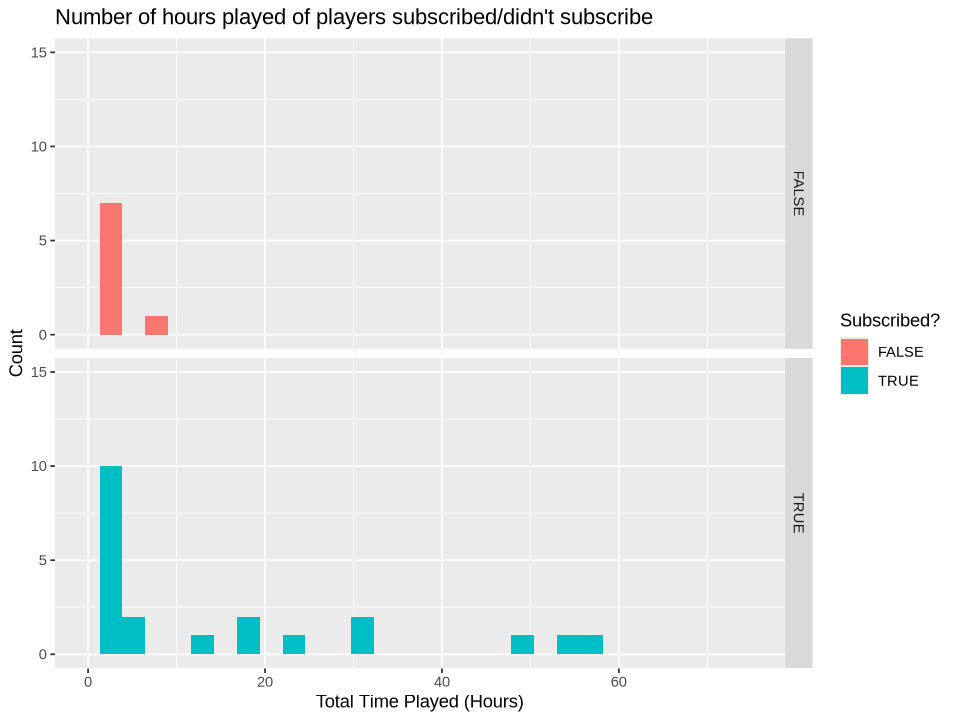

In [108]:
options(repr.plot.width = 8, repr.plot.height = 6)

# Histogram visualization of the relationship between played_hours and subscribe
players_played_hours_subscribe_plot <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram() +
    facet_grid(rows = vars(subscribe)) +
    labs(title = "Number of hours played of players subscribed/didn't subscribe", x = "Total Time Played (Hours)" , y = "Count", fill = "Subscribed?") +
    xlim(c(0, 75)) +
    ylim(c(0,15))
players_played_hours_subscribe_plot

This visualization illustrates that as `played_hours` increases, there are more people subscribing to a video game newsletter. Besides that there are no distinguishible patterns within the visualization

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


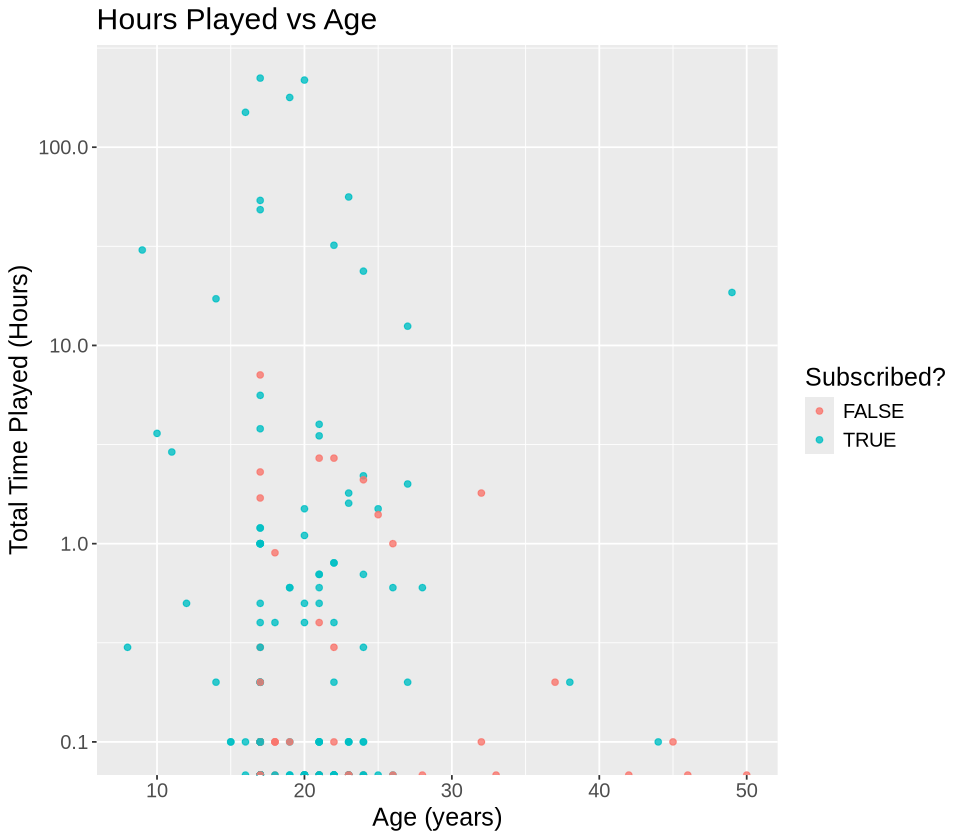

In [105]:
# Scatterplot visualization of the relationship between age, played_hours and subscribe
players_age_played_hours_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.8) + 
    labs(title = "Hours Played vs Age", x = "Age (years)", y = "Total Time Played (Hours)", color = "Subscribed?") +
    scale_y_log10() +
    theme(text = element_text(size = 15))
players_age_played_hours_plot

This visualization of `Age`, `played_hours`, and `subscribe` visualizases the relationship between all 3 columns. Besides a higher `played_hours` eluding to subscription of a video game newsletter, it is hard to distinguish if there is a linear relationship between `Age`, `played_hours`, and `subscribe`.  

Because each predictor variable(s) have hard, undistiguishible relationships with `subscribe` we will preform KNN classificaiton to predict whether or not a player will subscribe to a video game newsletter using just `Age` as a predictor, `played_hours` as a predictor, and both `Age` and `played_hours` as predictors. This is because the KNN algorithm makes no assumptions about data distribution/relationship shape.  

In order to use KNN classification we will first split the dataset into 70% Training and 30% Testing sets. In addition to that, scaling, tuning and cross-validation will be performed to determine the most accurate k-value for our algorithm and ensure optimized accuracy, precision, and recall metrics.

In [199]:
set.seed(1234)

players_split <- initial_split(players, prop = 0.7, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_age_recipe <- recipe(subscribe ~ Age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

# KNN algorithm model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# K-value tibble for cross validation
k_vals <- tibble(neighbors = seq(from = 1, to = 100))

knn_age_results <- workflow() |>
    add_recipe(players_age_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

# Pulling the best K-vale for just age as predictor
best_k_age <- knn_age_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k_age


[1] 23

In [190]:
set.seed(1234)

players_recipe_balance <- recipe(subscribe ~ ., data = players) |>
  step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
  prep()

upsampled_players <- bake(players_recipe_balance, players)

upsampled_players |>
  group_by(subscribe) |>
  summarize(n = n())

subscribe,n
<fct>,<int>
FALSE,142
TRUE,142


In [200]:
set.seed(1234) # Seed for possible recreation

# Spliting the dataframe into 70% Training and 30% Testing
players_split <- initial_split(players, prop = 0.7, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_split_2 <- initial_split(players, prop = 0.7, strata = subscribe)
players_training_2 <- training(players_split_2)
players_testing_2 <- testing(players_split_2)

players_split_3 <- initial_split(players, prop = 0.7, strata = subscribe)
players_training_3 <- training(players_split_3)
players_testing_3 <- testing(players_split_3)

# Checking the proportions of FALSE and TRUE subscriptions in original dataframe
player_proportions <- players |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(players))
player_proportions

# Checking the proportions of FALSE and TRUE subscriptions in training dataframe
player_training_proportions <- players_training |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(players_training))
player_training_proportions

# Checking the proportions of FALSE and TRUE subscriptions in testing dataframe
player_testing_proportions <- players_testing |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(players_testing))
player_testing_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,36,26.66667
TRUE,99,73.33333


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,16,27.11864
TRUE,43,72.88136


After creating our training\testing split and ensuring that proportions are similar to the original dataset, we can begin training our classifiers.

In [201]:
set.seed(1234) # Seed for possible recreation

# Recipe for just age as a predictor
players_age_recipe <- recipe(subscribe ~ Age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Recipe for just played_hours as a predictor
players_played_hours_recipe <- recipe(subscribe ~ played_hours, data = players_training_2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Recipe for age + played_hours as predictors
players_age_played_hours_recipe <- recipe(subscribe ~ played_hours + Age, data = players_training_3) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Vfold for cross validation of our algorithm
players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

# KNN algorithm model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# K-value tibble for cross validation
k_vals <- tibble(neighbors = seq(from = 1, to = 100))

# Then we perform cross validation for each recipe to ensure we have the most optimal K-value for each algorithm

# Workflow for KNN classifier with just age as predictor
knn_age_results <- workflow() |>
    add_recipe(players_age_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

# Pulling the best K-vale for just age as predictor
best_k_age <- knn_age_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k_age

# Workflow for KNN classifier with just played_hours as predictor
knn_played_hours_results <- workflow() |>
    add_recipe(players_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

# Pulling the best K-vale for just played_hours as predictor
best_k_played_hours <- knn_played_hours_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k_played_hours

# Workflow for KNN classifier with both age and played_hours as predictors
knn_age_played_hours_results <- workflow() |>
    add_recipe(players_age_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

# Pulling the best K-vale for both age and played_hours as predictors
best_k_age_played_hours <- knn_age_played_hours_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k_age_played_hours

[1] 27

[1] 49

[1] 24

Now that we've found the most optimized `k-values` for each KNN model. We can build specified KNN classificaiton models and test their accuracy

In [185]:
set.seed(1234) # Seed for possible recreation

knn_spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_age <- workflow() |>
  add_recipe(players_age_recipe) |>
  add_model(knn_spec_age) |>
  fit(data = players_testing)
    
players_age_test_prediction <- predict(knn_fit_age, players_testing) |>
    bind_cols(players_testing)

players_age_test_prediction_acc <- players_age_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_age_test_prediction_acc

players_age_test_prediction_conf <- players_age_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
players_age_test_prediction_conf





knn_spec_played_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_played_hours) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_played_hours <- workflow() |>
  add_recipe(players_played_hours_recipe) |>
  add_model(knn_spec_played_hours) |>
  fit(data = players_testing_2)
    
players_played_hours_test_prediction <- predict(knn_fit_played_hours, players_testing_2) |>
    bind_cols(players_testing_2)

players_played_hours_test_prediction_acc <- players_played_hours_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_played_hours_test_prediction_acc

players_played_hours_test_prediction_conf <- players_played_hours_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
players_played_hours_test_prediction_conf




knn_spec_age_played_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age_played_hours) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_age_played_hours <- workflow() |>
  add_recipe(players_age_played_hours_recipe) |>
  add_model(knn_spec_age_played_hours) |>
  fit(data = players_testing_3)
    
players_age_played_hours_test_prediction <- predict(knn_fit_age_played_hours, players_testing_3) |>
    bind_cols(players_testing_3)

players_age_played_hours_test_prediction_acc <- players_age_played_hours_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_age_played_hours_test_prediction_acc

players_age_played_hours_test_prediction_conf <- players_age_played_hours_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
players_age_played_hours_test_prediction_conf

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     16   43

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     16   43

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     16   43

In [193]:
set.seed(1234) # Seed for possible recreation

players_recipe_balance <- recipe(subscribe ~ ., data = players) |>
  step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
  prep()

upsampled_players <- bake(players_recipe_balance, players)

upsampled_players |>
  group_by(subscribe) |>
  summarize(n = n())

upsampled_players_split <- initial_split(upsampled_players, prop = 0.7, strata = subscribe)
upsampled_players_training <- training(upsampled_players_split)
upsampled_players_testing <- testing(upsampled_players_split)

upsampled_players_split_2 <- initial_split(upsampled_players, prop = 0.7, strata = subscribe)
upsampled_players_training_2 <- training(upsampled_players_split_2)
upsampled_players_testing_2 <- testing(upsampled_players_split_2)

upsampled_players_split_3 <- initial_split(upsampled_players, prop = 0.7, strata = subscribe)
upsampled_players_training_3 <- training(upsampled_players_split_3)
upsampled_players_testing_3 <- testing(upsampled_players_split_3)

# Checking the proportions of FALSE and TRUE subscriptions in original dataframe
upsampled_players_proportions <- upsampled_players |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(upsampled_players))
upsampled_players_proportions

# Checking the proportions of FALSE and TRUE subscriptions in training dataframe
upsampled_players_training_proportions <- upsampled_players_training |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(upsampled_players_training))
upsampled_players_training_proportions

# Checking the proportions of FALSE and TRUE subscriptions in testing dataframe
upsampled_players_testing_proportions <- upsampled_players_testing |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(upsampled_players_testing))
upsampled_players_testing_proportions

# Recipe for just age as a predictor
upsampled_players_age_recipe <- recipe(subscribe ~ Age, data = upsampled_players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Recipe for just played_hours as a predictor
upsampled_players_played_hours_recipe <- recipe(subscribe ~ played_hours, data = upsampled_players_training_2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Recipe for age + played_hours as predictors
upsampled_players_age_played_hours_recipe <- recipe(subscribe ~ played_hours + Age, data = upsampled_players_training_3) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Vfold for cross validation of our algorithm
upsampled_players_vfold <- vfold_cv(upsampled_players_training, v = 10, strata = subscribe)

# KNN algorithm model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# K-value tibble for cross validation
k_vals <- tibble(neighbors = seq(from = 1, to = 100))

# Then we perform cross validation for each recipe to ensure we have the most optimal K-value for each algorithm

# Workflow for KNN classifier with just age as predictor
upsampled_knn_age_results <- workflow() |>
    add_recipe(upsampled_players_age_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = upsampled_players_vfold, grid = k_vals) |>
    collect_metrics()

# Pulling the best K-vale for just age as predictor
upsampled_best_k_age <- upsampled_knn_age_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
upsampled_best_k_age

# Workflow for KNN classifier with just played_hours as predictor
upsampled_knn_played_hours_results <- workflow() |>
    add_recipe(upsampled_players_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = upsampled_players_vfold, grid = k_vals) |>
    collect_metrics()

# Pulling the best K-vale for just played_hours as predictor
upsampled_best_k_played_hours <- upsampled_knn_played_hours_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
upsampled_best_k_played_hours

# Workflow for KNN classifier with both age and played_hours as predictors
upsampled_knn_age_played_hours_results <- workflow() |>
    add_recipe(upsampled_players_age_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = upsampled_players_vfold, grid = k_vals) |>
    collect_metrics()

# Pulling the best K-vale for both age and played_hours as predictors
upsampled_best_k_age_played_hours <- upsampled_knn_age_played_hours_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
upsampled_best_k_age_played_hours

subscribe,n
<fct>,<int>
FALSE,142
TRUE,142


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,142,50
TRUE,142,50


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,99,50
TRUE,99,50


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,43,50
TRUE,43,50


[1] 9

[1] 1

[1] 7

## Discussion